# Table of Contents


1. [Introduction](#Introduction)
2. [Data Preparation](#Data%20Preparation)
3. [Modeling](#Modeling)
4. [Evaluation](#Evaluation)
5. [Deployment and Interfacing](#Deployment%20and%20Interfacing)

# Introduction

In this project, we will be building a Machine Learning model that performs Optical Character Recognition (OCR) to automatically scan an identification document, extract relevant data, and store it in a structured format that can be easily analyzed.

![intro_image](https://itsupplychain.com/wp-content/uploads/2019/11/Driving-License-Scanning-900x636.jpg)

First, we will start off by detailing some relevant datasets used for this project. Then, we build several Machine Learning models and proceed to evaluate them. Finally, we create a small Flask API that will be used as a server.

# ID Pre-processing

As an initial step in our pipeline, we need to extract the location of the ID in the image that is provided, and we need to crop it. To do so, we use openCV and the *Canny Edge Detector* to detect rectangular edges in the image. Then, we select the largest one by computing the areas of the rectangle. This would work because the assumption is that the ID would be the main thing in the image, and as such, would cover the biggest area.

For information about the detector, refer to the [docs](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html).

In [1]:
import cv2

def load_and_crop_image(path):
    """
    Load an image from a file and perform image processing to detect the largest contour in the image,
    which is assumed to be the ID card in the image. Then, return the original image with a rectangle
    drawn around the ID card and the coordinates of the bounding box around the contour.

    Parameters
    ----------
    path : str
        The path to the image file.

    Returns
    -------
    tuple
        A tuple containing the original image with a rectangle drawn around the ID card and the coordinates
        of the bounding box around the contour. The first element of the tuple is the image and the second element
        is a tuple of four integers representing the x and y coordinates of the top-left corner of the bounding box,
        as well as the width and height of the bounding box.

    """
    # Load the image
    image = cv2.imread(path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection to find edges
    edges = cv2.Canny(blur, 50, 200)

    # Find contours in the edges image
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



    # Get the contour with the largest area (assuming it is the ID card)
    mx = (0,0,0,0)      # biggest bounding box so far
    mx_area = 0
    for cont in contours:
        x,y,w,h = cv2.boundingRect(cont)
        area = w*h
        if area > mx_area:
            mx = x,y,w,h
            mx_area = area
    x,y,w,h = mx



    # Get the coordinates of the bounding box around the contour
    image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image, (x,y,w,h)


Let's look at an example in action:

([], [])

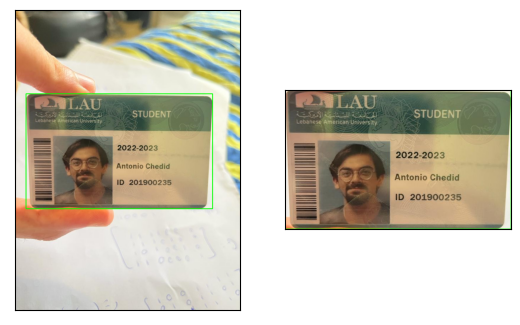

In [2]:
import matplotlib.pyplot as plt

# Use the function defined above
bounded, (x,y,w,h) = load_and_crop_image('./images/test_2.jpeg')

# Plot the image
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(bounded, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(bounded[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])

As can be seen, the ID was detected -and its borders highlighted in green-, and then cropped.

Let's try out a couple of other ids:

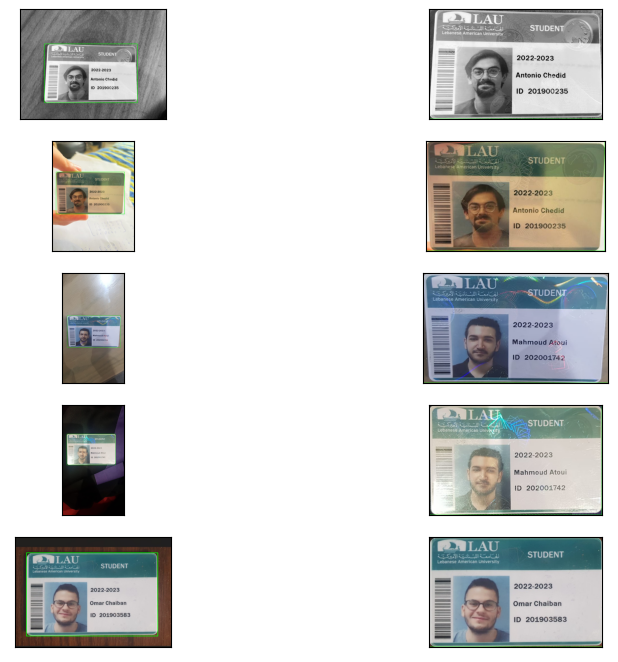

In [3]:
plt.figure(figsize=(10,10))

base_filename = "test"

count = 1
for index in range(1, 6):
    filename = base_filename + f"_{index}.jpeg"
    
    bounded, (x,y,w,h) = load_and_crop_image(f"./images/{filename}")

    plt.subplot(6,2,count)
    plt.imshow(cv2.cvtColor(bounded, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    count+=1
    plt.subplot(6,2,count)
    plt.imshow(cv2.cvtColor(bounded[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    count+=1


The function can be seen to be working properly.

Next in our pipeline, we need to determine the location of the text fields. To do so, we use the *EAST Text Detector Model*. This model is also available in OpenCV and is widely used to detect the location of text in an image. 

In short, EAST detector is a deep learning model that detects text in natural scene images. It consists of a fully concolutional neural network that takes an iamge as input and outputs a score map, which indicates the probability of each pixel being part of a text region. It also outputs geometry map, which encodes the location and orientation of the text region. During inference, the model performs a sliding window over the input image and applies non-maximum suppression to the predicted bounding boxes to remove duplicates and overlapping boxes in order to retain only the most confident detections.


For more details, please refer to the developer's [Github](https://github.com/immanuvelprathap/OpenCV-Tesseract-EAST-Text-Detector).

In [4]:
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression


def extract_text_boxes(cropped_image):
    """
    Detects and extracts bounding boxes around text regions in a cropped image using the EAST text detector model.

    Parameters
    ----------
    cropped_image : numpy array
        A 3D array representing the cropped image.

    Returns
    -------
    tuple
        A tuple containing the following two items:
        1. numpy array
            A copy of the original image with bounding boxes drawn around text regions.
        2. list
            A list of lists, where each inner list represents a bounding box and contains the (startX, startY, endX, endY) coordinates in pixels of the box.

    Notes
    -----
    The EAST text detector model used in this function is trained to detect text in natural scenes and can be found in the 'models' directory.

    """
    
    # Load the image
    orig = cropped_image.copy()

    # Set the ratio of the new width to the old width and compute the new height
    (newW, newH) = (320, 320)
    rW = cropped_image.shape[1] / float(newW)
    rH = cropped_image.shape[0] / float(newH)

    # Resize the image and get the new dimensions
    image = cv2.resize(cropped_image, (newW, newH))
    (H, W) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Load the pre-trained EAST text detector model
    net = cv2.dnn.readNet('./models/frozen_east_text_detection.pb')

    # Construct a blob from the image and set the input for the EAST model
    blob = cv2.dnn.blobFromImage(image, 3, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Forward pass through the EAST model and get the scores and geometry
    (scores, geometry) = net.forward(layerNames)


    # Grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        # Extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]


       # Loop over the number of columns
        for x in range(0, numCols):
            # If our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
            # Compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # Extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # Use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # Compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # Add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes

    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Loop over the bounding boxes
    count = 1
    updated_boxes = []
    for (startX, startY, endX, endY) in boxes:
        # Scale the bounding box coordinates based on the respective ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        
        updated_boxes.append([startX, startY, endX, endY])

        # Draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 1)
        
    
    return orig, updated_boxes

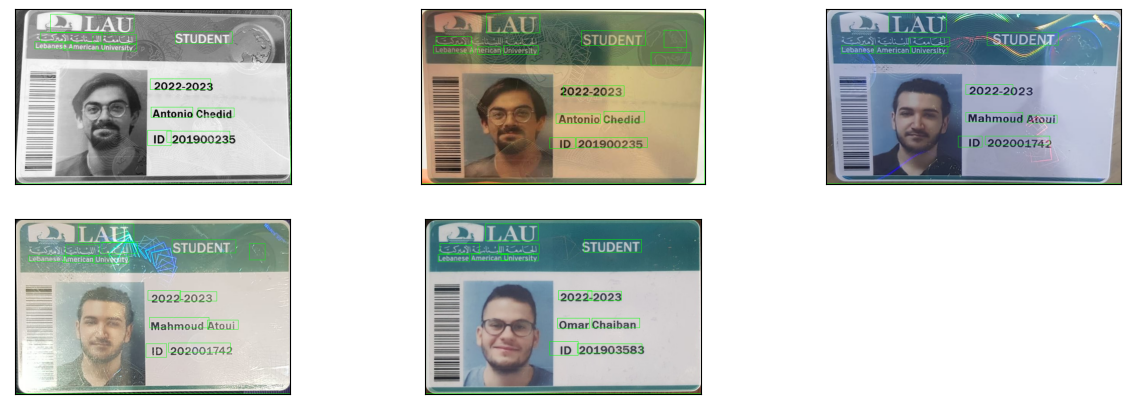

In [5]:
plt.figure(figsize=(15,5))

for index in range(1,6):
    bounded, (x,y,w,h) = load_and_crop_image(f"./images/test_{index}.jpeg")
    image, boxes = extract_text_boxes(bounded[y:y+h, x:x+w])

    plt.subplot(2,3, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])

Now that all the text boxes in the images are detected, we want to map each one to what it represents. To do so, we will crop the image into regions and extract the corresponding boxes for each. 

To start with, we define a function that takes in an image and a region, and outputs the bounding boxes in that region only. To be able to determine whether the boxes lie in the region, they be entirely contained in the *desired area*; that is, their left corners are to the right of the area's left corners, and their right corners are to the left of the right area.

In [6]:
def get_boxes_in_region(image, desired_area):
    """
    Returns a list of bounding boxes (4-tuple) found within the specified area.

    Parameters:
    -----------
    image : numpy.ndarray
        Input image without bounding boxes.
    desired_area : tuple
        A 4-tuple specifying the desired area to search for bounding boxes.
        The format of the 4-tuple is (min_y, max_y, min_x, max_x).

    Returns:
    --------
    filtered_boxes : list
        A list of 4-tuples, where each tuple specifies the (x, y) coordinates of
        the top-left and bottom-right corners of the bounding box.
    """
    
    _, boxes = extract_text_boxes(bounded)
    
    filtered_boxes = [box for box in boxes if box[1] > desired_area[0] and box[3] < desired_area[1] and box[0] > desired_area[2] and box[3]< desired_area[3]]

    return filtered_boxes

We apply this logic to extract the *type* of the id; that is, to see whether the id corresponds to a student or a faculty member. This information lies in the upper-right quadrant of the picture

([], [])

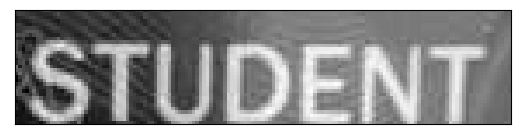

In [7]:
# Load the image
bounded, (x,y,w,h) = load_and_crop_image("./images/test_2.jpeg")

# Crop the image
bounded = bounded[y:y+h, x:x+w]

# Get image dimensions
len_x, len_y = len(bounded[0]), len(bounded[1])


#start Y, endY, startX, endX
desired_area = [0, int(len_y*0.25), int(len_x*0.51), len_x]

# Filter according to region
filtered_boxes_type = get_boxes_in_region(bounded, desired_area)

# Take the zeroth element to account for possible mis-classifications
type_box = sorted(filtered_boxes_type, key=lambda x: x[0])[0]


section = bounded[type_box[1]:type_box[3], type_box[0]:type_box[2]]
gray_section = cv2.cvtColor(section, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_section, cmap="gray")
plt.xticks([])
plt.yticks([])

We can see above that the region was correctly extracted.

Next, we deal with the year. We follow a similar logic to the one above, but with a different desired area.

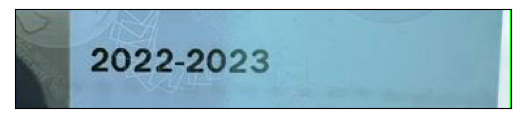

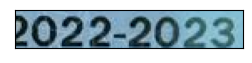

In [8]:
#startY, endY, startX, endX
desired_area_year = [int(len_y*0.23), int(len_y*0.35), int(len_x*0.4), len_x]

plt.imshow(bounded[desired_area_year[0]:desired_area_year[1], desired_area_year[2]:desired_area_year[3]])
plt.xticks([])
plt.yticks([])


filtered_boxes = get_boxes_in_region(bounded, desired_area_year)

filtered_boxes_year = sorted(filtered_boxes, key=lambda x: x[0])


sections_year = [
    bounded[box[1]:box[3], box[0]:box[2]]
    for box in filtered_boxes_year
]

plt.figure(figsize=(10, 5))

for pos, section in enumerate(sections_year):
    plt.subplot(len(sections_year) // 3 + 1, 3, pos + 1)
    plt.imshow(section, cmap="gray")
    plt.xticks([])
    plt.yticks([])


We do the same thing for the name:

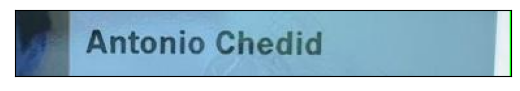

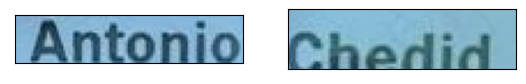

In [9]:
#startY, endY, startX, endX
desired_area_name = [int(len_y*0.35), int(len_y*0.43), int(len_x*0.4), len_x]

plt.imshow(bounded[desired_area_name[0]:desired_area_name[1], desired_area_name[2]:desired_area_name[3]])
plt.xticks([])
plt.yticks([])

filtered_boxes = get_boxes_in_region(bounded, desired_area_name)

filtered_boxes_name = sorted(filtered_boxes, key=lambda x: x[0])

# Crop the image to get the different sections based on the filtered bounding boxes
sections_name = [
    bounded[box[1]:box[3], box[0]:box[2]]
    for box in filtered_boxes_name
]



plt.figure(figsize=(10, 5))

for pos, section in enumerate(sections_name):
    plt.subplot(len(sections_name) // 3 + 1, 3, pos + 1)
    plt.imshow(section, cmap="gray")
    plt.xticks([])
    plt.yticks([])




And finally for the ID:

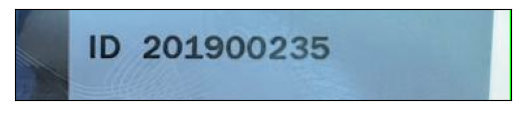

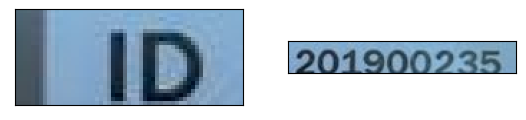

In [10]:
#startY, endY, startX, endX
desired_area_id = [
    int(len_y * 0.43),
    int(len_y * 0.54),
    int(len_x * 0.4), len_x
]

plt.imshow(bounded[desired_area_id[0]:desired_area_id[1],
                   desired_area_id[2]:desired_area_id[3]])
plt.xticks([])
plt.yticks([])

filtered_boxes = get_boxes_in_region(bounded, desired_area_id)

filtered_boxes_ids = sorted(filtered_boxes, key=lambda x: x[0])
sections_id = [
    bounded[box[1]:box[3], box[0]:box[2]]
    for box in filtered_boxes_ids
]

plt.figure(figsize=(10, 5))

for pos, section in enumerate(sections_id):
    plt.subplot(len(sections_id) // 3 + 1, 3, pos + 1)
    plt.imshow(section, cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [15]:
def extract_single_characters(image):
    """
    Extracts individual characters from an image using the Maximally Stable 
    Extremal Regions (MSER) algorithm.

    Parameters
    ----------
    image : numpy.ndarray
        The input image, as a numpy array of shape (height, width, channels).

    Returns
    -------
    rects : list of tuples
        A list of bounding boxes around each extracted character, expressed as
        tuples of four integers (x, y, width, height). The (x, y) coordinates are
        the top-left corner of the box, and the width and height are its dimensions.
    """
    
    
    img = image.copy()
    

    (h, w) = img.shape[:2]
    image_size = h*w
    mser = cv2.MSER_create()
    mser.setMaxArea(image_size//2)
    mser.setMinArea(10)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
    _, bw = cv2.threshold(gray, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    regions, rects = mser.detectRegions(bw)
    
    
    plt.figure(figsize=(10,10))
    for pos, (x, y, w, h) in enumerate(rects):
        plt.subplot(len(rects) // 5 + 1, 5, pos+1)
        plt.imshow(gray[y:y+int(h*10), x:x + int(w*1.1)], cmap="gray")
        cv2.rectangle(img, (x, y), (x+w, y+h), color=(255, 0, 255), thickness=1)
        
    return img


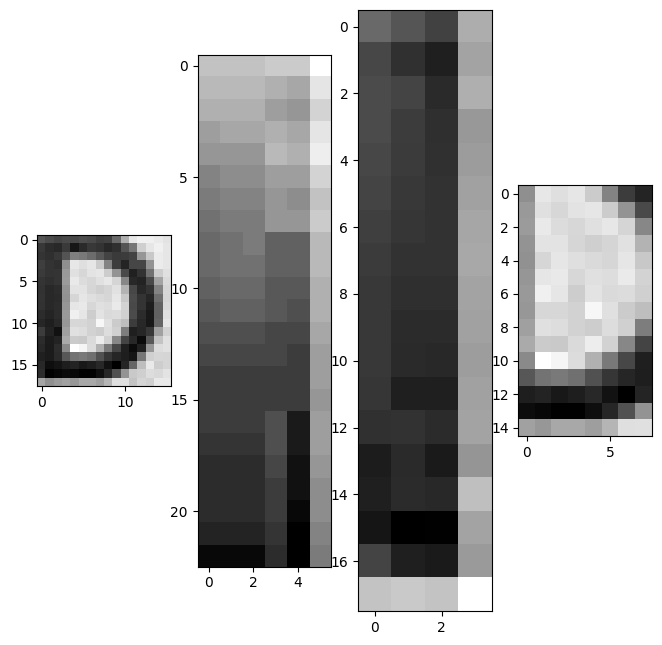

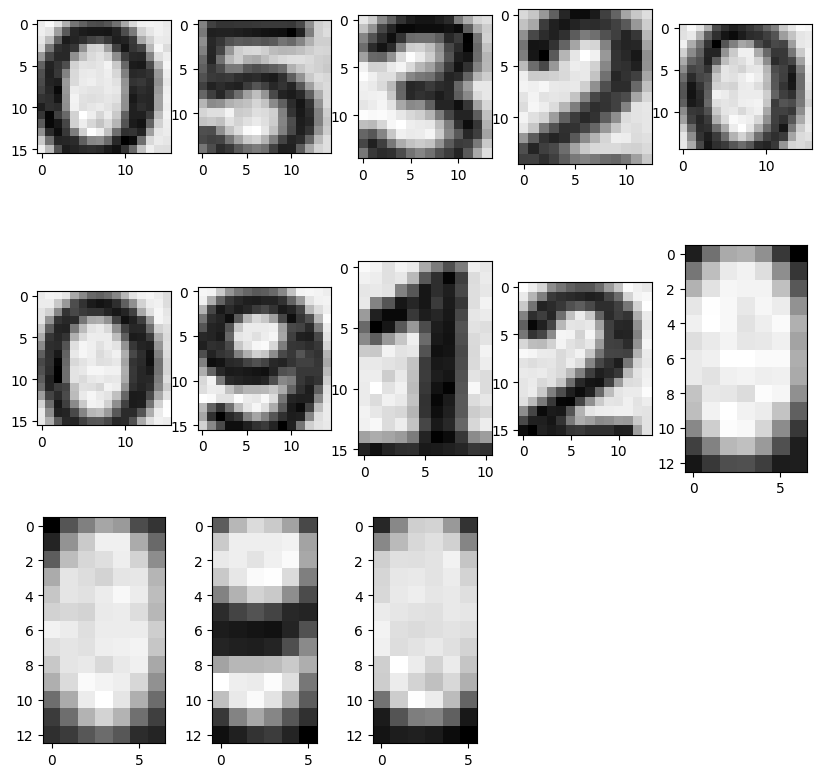

In [16]:
for section in sections_id:
    img = extract_single_characters(section)

From the images above, we can see that we have some erroneous results. Let's look at the original images with the bounding boxes added on it:

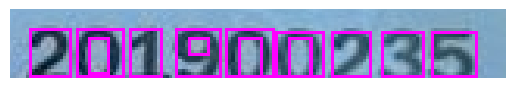

In [20]:
plt.imshow(img)
plt.axis("off");

We can see that letters with a circle in side of them (e.g., 0 and 9) have sume duplicate boxes. 

To fix this, we can write a function that removes boxes contained within other boxes.

To be able to determine whether a box is contained within *any* other box, we first get all possible combinations of boxes and check for each if either is container in the other. 

In [21]:
import itertools

def filter_out_contained(rects):
    """
    Removes bounding boxes contained within other bounding boxes.
    
    Parameters
    ----------
    rects : list
        List of bounding boxes, where each bounding box is represented by a tuple (x, y, w, h) of integers.

    Returns
    -------
    list
        A filtered list of bounding boxes, where each bounding box is represented by a tuple (x, y, w, h) of integers.

    """
    
    outputs = {str(k):False for k in rects}
    
    # Get all possible combinations 
    combs = itertools.combinations(rects, 2)
    for rect1, rect2 in combs:
        x1,y1,w1,h1 = rect1
        x2,y2,w2,h2 = rect2
        
        # Check if second is contained in first
        if x2 >= x1 and x2+w2 <= x1+w1 and y2 >= y1 and y2+h2 <= y1+h1:
            outputs[str(rect2)] = True
            
        # Check if first is contained in second
        elif x1>=x2 and x1+w1 <= x2+w2 and y1 >= y2 and y1+h1 <= y2+h2:
            outputs[str(rect1)] = True
            
                        
    # Fill in output dictionary
    new_output = []
    
    for rect in rects:
        if outputs[str(rect)] == False:
            new_output.append(rect)
            
            
    return new_output
   

Now we redefine the *extract_single_characters* function, this time using the *filter* function to remove boxes contained within others.

In [29]:
def extract_single_characters(image):
    img = image.copy()
    

    (h, w) = img.shape[:2]
    image_size = h*w
    mser = cv2.MSER_create()
    mser.setMaxArea(image_size//2)
    mser.setMinArea(10)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting to GrayScale
    _, bw = cv2.threshold(gray, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    regions, rects = mser.detectRegions(bw)
    
    
    rects = filter_out_contained(rects)

    plt.figure(figsize=(10,10))
    for pos, (x, y, w, h) in enumerate(rects):
        plt.subplot(len(rects) // 5 + 1, 5, pos+1)
        plt.imshow(gray[y:y+int(h*10), x:x + int(w*1.1)], cmap="gray")
        cv2.rectangle(img, (x, y), (x+w, y+h), color=(255, 0, 255), thickness=1)
        
    return img

Let's look at the new results:

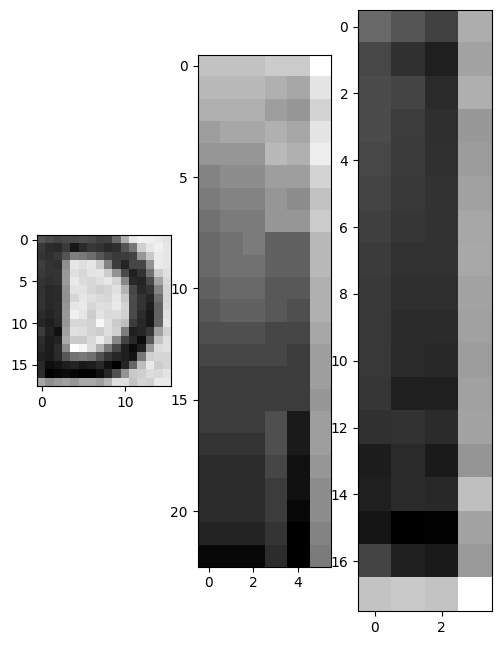

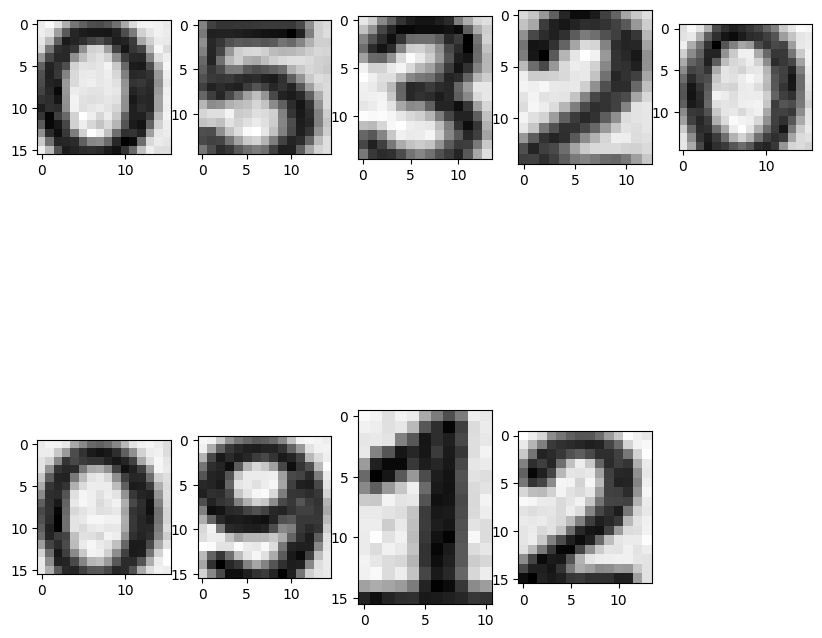

In [32]:
for section in sections_id:
    img = extract_single_characters(section)

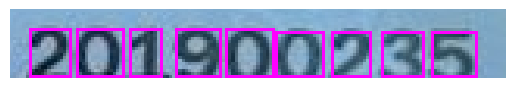

In [33]:
plt.imshow(img)
plt.axis("off");

We can see that the issue has been fixed.

## Detecting the Image

Next, we need to detect the image that is on the ID. To do so, we use the Haar Cascade Classifiers.

### Haar Cascades and Face Detection

**Haar classifiers** (presented by Paul Viola and Michael Jones) are classifiers that were used in the first real-time face detector. A Haar classifier, or a Haar cascade classifier, is a machine learning object detection program that identifies objects in an image and video.


The algorithm can be explained in four stages:
<li>Calculating Haar Features</li>
<li>Creating Integral Images</li>
<li>Using Adaboost</li>
<li>Implementing Cascading Classifiers</li>





#### Calculating Haar Features

A Haar feature is essentially calculations that are performed on adjacent rectangular regions at a specific location in a detection window. The calculation involves summing the pixel intensities in each region and calculating the differences between the sums. Here are some examples of Haar features below.

|<img src="https://miro.medium.com/max/828/1*yl-BqUzycbyfhPAzwWOddQ.webp" width="300" height="300"/> | <img src="https://miro.medium.com/max/1400/1*gl4JHntNPHQt1G7txpiRMA.webp" width="500" height="300"/>|
|-|-|

#### Creating Integral Images

Since such features can be difficult to calculate for a large image, integral images can be used because the number of operations are greatly reduced.

Instead of computing at every pixel, integral images create sub-rectangles and array references for each one of these sub-rectangles. These rectangles are then used to compute the Haar features.

Below is an example of how an integral image works
<img src="https://miro.medium.com/max/1100/1*dy_lV_6Ne8KSeOWoWB1kAw.webp"/>

But, an issue still arises, as we don't care about all the features in an image. Naturally, we only care about the features of the objects -in our case, faces- that we want to detect.

To be able to determine the important features, an algorithm called Adaboost -Adaptive Boosting- is used.

#### Adaboost Training

Adaboost training consists of using a combination of weak and strong classifiers to be able to successfully detect object.

* A weak classifier is basically a binary classification model that is said to perform slightly better than random guessing. In other words, classifiers that achieve slightly > 50% accuracy.

* A strong classifier, on the other hand, is a classification model that performs much better than random guessing.

What Adaboost does is combine several weak models to *boost* their performance, thus making the overall model a strong one. This technique is usually done because weak learners are easy to develop, while strong learners are harder to develop and understand.

Specifically, Adaboost's weak learners are created by moving a window over the input image, and computing Haar features for each subsection of the image. This difference is compared to a learned threshold that separates non-objects from objects. Because these are “weak classifiers,” a large number of Haar features is needed for accuracy to form a strong classifier.

<img src="https://miro.medium.com/max/1400/1*8cADlNiEJa5RAu4LqY4dgA.webp"/>

The last step thus consists of combining these models

#### Cascading Classifiers

As was discussed above, we need to cascade the different weak learners to boost the entire model into a strong learner.

For a more detailed look into the Haar Classifiers, a link for the paper where it was introduced by Paul Viola and Michael Jones can be found
[here](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf).

### Implementation

We proceed by implementing the Haar Classifiers:

In [36]:
def detect_face_from_image(img):
    """
    Detects the face from an image using OpenCV's Haar Cascade classifier.

    Parameters
    ----------
    img : numpy.ndarray
        The input image, represented as a NumPy array of shape (height, width, channels).

    Returns
    -------
    numpy.ndarray, tuple
        A tuple of two values is returned. The first value is the image with the detected face, represented
        as a NumPy array of shape (height, width, channels). The second value is a tuple of four integers, 
        representing the coordinates of the bounding box of the detected face in the format (x, y, width, height).

    Raises
    ------
    None
    """
        
    image = img.copy()
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # resize image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # face classifier
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    # When no faces detected, face_classifier returns and empty tuple
    if len(faces) == 0:
        print("No faces found")

    # We iterate through our faces array and draw a rectangle
    # over each face in faces
    for (x, y, w, h) in faces:
        y = y - 30 # Same here...
        w = int(w *0.7)

        cv2.rectangle(image, (x, y), (x + w + 50, y + h + 70), (27, 200, 10), 2)

    return image, faces[0]


Let's test this function on an image:

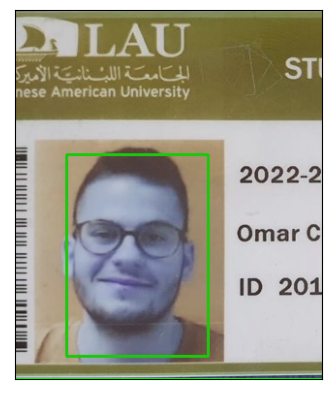

In [37]:
image, (id_x, id_y, id_w, id_h) = load_and_crop_image("./images/test_5.jpeg")
img = image[id_y:id_y+id_h, id_x:id_x+id_w]


#startY, endY, startX, endX
desired_area_id = [
    int(len_y * 0),
    len_y,
    int(len_x * 0.1), int(len_x*0.6)
]

plt.imshow(img[desired_area_id[0]:desired_area_id[1],
                   desired_area_id[2]:desired_area_id[3]])

img = img[desired_area_id[0]:desired_area_id[1],
                   desired_area_id[2]:desired_area_id[3]]
plt.xticks([])
plt.yticks([])


#plt.imshow(img)
img, face_coordinates = detect_face_from_image(img)
plt.imshow(img)

Finally, to be able to use the image, we need to convert it to base64 string. We do so below:

In [38]:
import base64
def im_to_base(image):
    """
    Convert a NumPy array that represents an image into a base64 string.

    Parameters
    ----------
    image : np.ndarray
        The NumPy array that represents the image to be converted.

    Returns
    -------
    str
        The base64 string representation of the input image.
    """
        
    # Convert image to bytes
    _, buffer = cv2.imencode('.jpg', image)
    
    # Encode bytes as base64 string
    img_str = base64.b64encode(buffer).decode('utf-8')
    
    return img_str

To showcase what's happening, let's extract the face, convert it to base, then convert it back to an image to display here:

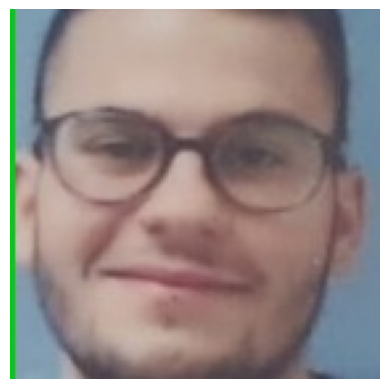

In [39]:
from io import BytesIO
from PIL import Image

image, (id_x, id_y, id_w, id_h) = load_and_crop_image("./images/test_5.jpeg")
img = image[id_y:id_y+id_h, id_x:id_x+id_w]
img, (face_x, face_y, face_w, face_h) = detect_face_from_image(img)

face = img[face_y:face_y+face_h, face_x:face_x+face_w]
base_str = im_to_base(face)


# Decode the base64 string into bytes
img_bytes = base64.b64decode(base_str)

# Create an image object from the bytes
img = Image.open(BytesIO(img_bytes))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Modeling and Evaluation

Moving forward, we need to build, train, and evaluate ML models that can analyze the text images seen in this notebook to be able to predict what the letter in the image represents.

This section can be found in the other notebooks in this submission.

# Deployment and Interfacing

A mobile application was developed using React Native, in addition to a Flask API to interface between the models and the application. These can be found in their respective folders in the submission.

# References

https://docs.opencv.org/4.3.0/da/d0c/tutorial_bounding_rects_circles.html

https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html